# Imports

In [62]:
from getpass import getpass
import urllib
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import tensorflow.keras as keras

In [4]:
from keras import layers, Sequential
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load Data

In [6]:
df_path= os.getcwd()+'/drive/MyDrive/Sub_Data/data_13_G.pickle'

In [7]:
df = pd.read_pickle(df_path)
df

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,Labels
0,27.555986,88.491943,-20.645388,18.461662,-22.876869,26.373840,-7.842380,5.040419,-10.529922,30.722309,8.053223,25.249620,-3.851202,disco
1,21.160398,99.239639,-33.311604,24.493477,-17.089005,25.532211,-5.425315,11.550676,-12.097195,27.441135,0.058880,19.927771,-11.912487,disco
2,-13.337629,112.291656,-48.217140,38.652039,-11.287874,30.100903,-4.544308,16.824894,-15.798969,27.857822,-13.360273,20.098824,-20.572792,disco
3,-40.871708,116.767059,-47.124802,49.234226,-17.217890,37.331268,-0.842096,16.252968,-20.979574,27.505018,-24.680790,19.476368,-18.812157,disco
4,-67.497528,117.398331,-47.275208,47.681198,-16.081495,43.743324,13.473402,14.318071,-27.892868,20.559271,-31.776064,17.269453,-14.578279,disco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233175,-101.685333,23.818932,0.495472,30.757507,17.166796,16.255051,18.272770,9.566826,11.331477,4.932149,9.956822,12.857517,7.169489,reggae
1233176,-136.458862,21.216267,-1.512686,37.810467,22.128681,20.463276,16.296101,12.380598,18.769466,8.667844,15.075156,15.303005,7.611032,reggae
1233177,-167.509811,25.255136,0.489490,48.138466,27.790737,23.130043,17.280693,13.791199,17.217871,7.926507,13.045273,12.954222,9.367888,reggae
1233178,-152.141953,51.688583,-4.779652,27.629368,14.154837,21.258694,11.772314,17.563957,16.069324,20.217516,16.887005,8.754175,-7.446566,reggae


In [8]:
def process_df(df):
    '''
    Input: dataframe object
    Output: returns a 3d nparray
    '''
    inputs = df.iloc[0*130:0+1*130,:-1] #getting the first 130 rows
    inputs = np.expand_dims(inputs,0)   #expanding the shape of the array by inserting a new axis at the first position
    targets= [df.iloc[0*130,-1]]
    for i in range(1, int(df.shape[0]/130)): #repeating the above process for the entirety of the remaining dataset
        dummy_x = df.iloc[i*130:(i+1)*130, :-1].values
        dummy_x = np.expand_dims(dummy_x,0)
        dummy_y = df.iloc[i*130,-1]
        inputs = np.concatenate((inputs, dummy_x), axis=0)
        targets.append(dummy_y)
    return inputs, targets

In [9]:
inputs, targets = process_df(df)

In [10]:
#encoding categorical values 
encoder = LabelEncoder()
targets = encoder.fit_transform(targets) #encoded the categorical values in our target class 

In [11]:
np.unique(targets)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
#Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size = 0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# MLP Model

In [13]:
#Building a neural network model
model = keras.Sequential([
    #input layer
    keras.layers.Flatten(input_shape = (X_train.shape[1], X_train.shape[2])),

    #1st dense layer
    keras.layers.Dense(512, activation = 'relu'),

    #2nd dense layeer
    keras.layers.Dense(256, activation = 'relu'),

    #3rd dense layer
    keras.layers.Dense(64, activation = 'relu'),

    #output layer
    keras.layers.Dense(10,activation ='softmax')
])

In [14]:
#compile model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1690)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               865792    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


In [16]:
#train the network
nn_model = model.fit(X_train, y_train,
                    validation_data = (X_validation, y_validation),
                    epochs=70,
                    batch_size=128)

Epoch 1/70
48/48 [==============================] - 1s 21ms/step - loss: 11.5536 - accuracy: 0.2786 - val_loss: 5.9545 - val_accuracy: 0.3445
Epoch 2/70
48/48 [==============================] - 1s 18ms/step - loss: 4.3889 - accuracy: 0.3662 - val_loss: 3.7720 - val_accuracy: 0.3669
Epoch 3/70
48/48 [==============================] - 1s 18ms/step - loss: 2.5252 - accuracy: 0.3842 - val_loss: 2.3810 - val_accuracy: 0.3412
Epoch 4/70
48/48 [==============================] - 1s 17ms/step - loss: 1.8503 - accuracy: 0.4094 - val_loss: 2.2190 - val_accuracy: 0.3735
Epoch 5/70
48/48 [==============================] - 1s 17ms/step - loss: 1.6436 - accuracy: 0.4511 - val_loss: 2.1609 - val_accuracy: 0.3841
Epoch 6/70
48/48 [==============================] - 1s 18ms/step - loss: 1.5043 - accuracy: 0.4855 - val_loss: 2.1567 - val_accuracy: 0.4051
Epoch 7/70
48/48 [==============================] - 1s 17ms/step - loss: 1.3917 - accuracy: 0.5161 - val_loss: 2.1175 - val_accuracy: 0.4084
Epoch 8/70
4

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2, figsize=(10,10))
        

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="validation accuracy")
    axs[0].set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left',prop={'size': 20})
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history["val_loss"], label="validation loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 20})
    axs[1].set_title("Loss eval")
    fig.tight_layout(pad=3.0)
    plt.savefig('NN_train_test_overfitting.png')
    plt.show()


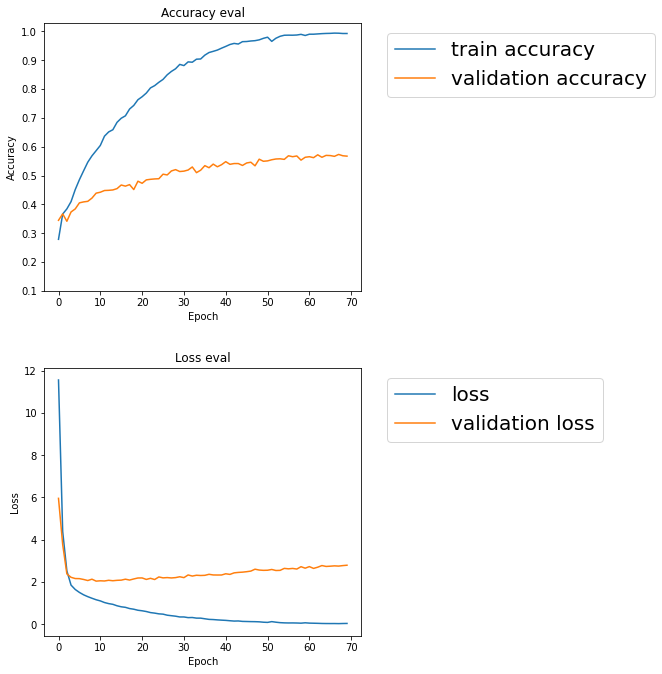

In [95]:
plot_history(nn_model)

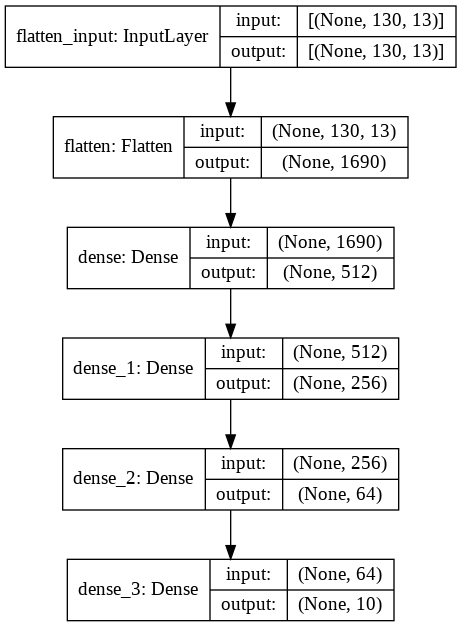

In [84]:
tf.keras.utils.plot_model(model, to_file='MLP_model_overfit.png', show_shapes=True)

# Solving overfitted MLP model by hyperparameter tuning

In [28]:
#Solving the overfitted neural network model
new_model = keras.Sequential([
    #input layer
    keras.layers.Flatten(input_shape = (X_train.shape[1], X_train.shape[2])),

    #1st dense layer
    keras.layers.Dense(512, activation = 'relu', kernel_regularizer=keras.regularizers.l2(0.001)), #L2: Sum of the squared weights.
    keras.layers.Dropout(0.3),

    #2nd dense layer
    keras.layers.Dense(256, activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    #3rd dense layer
    keras.layers.Dense(64, activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.001)),
    # keras.layers.Dropout(0.3),

    #output layer
    keras.layers.Dense(10,activation ='softmax')
])

In [29]:
#compile model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
new_model.compile(optimizer = optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               865792    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

In [31]:
#train_model
history = new_model.fit(X_train, y_train,
                    validation_data = (X_validation, y_validation),
                    epochs=70,
                    batch_size=128)

Epoch 1/70
48/48 [==============================] - 1s 23ms/step - loss: 35.1181 - accuracy: 0.1773 - val_loss: 7.0043 - val_accuracy: 0.2991
Epoch 2/70
48/48 [==============================] - 1s 19ms/step - loss: 12.5525 - accuracy: 0.2198 - val_loss: 3.6728 - val_accuracy: 0.3076
Epoch 3/70
48/48 [==============================] - 1s 19ms/step - loss: 7.7248 - accuracy: 0.2301 - val_loss: 2.6090 - val_accuracy: 0.3320
Epoch 4/70
48/48 [==============================] - 1s 19ms/step - loss: 5.5298 - accuracy: 0.2484 - val_loss: 2.2373 - val_accuracy: 0.3307
Epoch 5/70
48/48 [==============================] - 1s 19ms/step - loss: 4.3152 - accuracy: 0.2687 - val_loss: 2.0395 - val_accuracy: 0.3426
Epoch 6/70
48/48 [==============================] - 1s 19ms/step - loss: 3.6466 - accuracy: 0.2671 - val_loss: 1.9649 - val_accuracy: 0.3254
Epoch 7/70
48/48 [==============================] - 1s 19ms/step - loss: 3.1546 - accuracy: 0.2601 - val_loss: 1.9361 - val_accuracy: 0.3360
Epoch 8/70


In [96]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2, figsize=(10,10))
        

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="validation accuracy")
    axs[0].set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left',prop={'size': 20})
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history["val_loss"], label="vaildation loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 20})
    axs[1].set_title("Loss eval")
    fig.tight_layout(pad=3.0)
    plt.savefig('NN_train_test_overfitting_solved.png')
    plt.show()

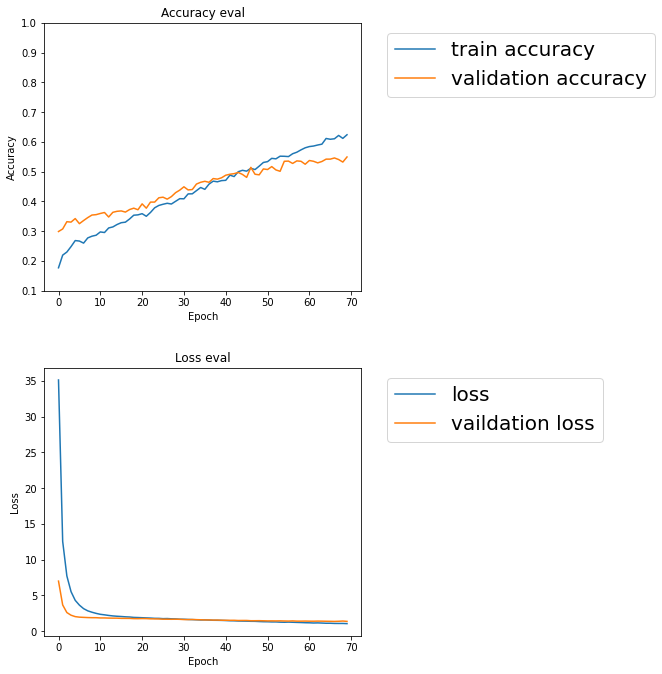

In [97]:
plot_history(history)

# Evaluating Model

In [36]:
#Evalution model on test set
test_loss, test_acc = new_model.evaluate(X_test, y_test, verbose = 2)
print(f'Test Accuracy: {test_acc}')

60/60 - 0s - loss: 1.4549 - accuracy: 0.5369
Test Accuracy: 0.5368809103965759


In [61]:
genres = encoder.inverse_transform(np.unique(targets))
genres

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

## Classification Report

In [63]:
predictions = new_model.predict(X_test)
predicted_indexes= np.argmax(predictions, axis=1)
print(classification_report(y_test, predicted_indexes,target_names = genres))


              precision    recall  f1-score   support

       blues       0.45      0.44      0.45       178
   classical       0.74      0.85      0.79       178
     country       0.38      0.45      0.41       183
       disco       0.47      0.42      0.44       196
      hiphop       0.47      0.40      0.43       197
        jazz       0.53      0.46      0.49       178
       metal       0.68      0.81      0.74       196
         pop       0.70      0.81      0.75       197
      reggae       0.45      0.44      0.45       188
        rock       0.39      0.30      0.34       207

    accuracy                           0.54      1898
   macro avg       0.53      0.54      0.53      1898
weighted avg       0.53      0.54      0.53      1898



## Confusion Matrix

In [70]:
cf = confusion_matrix(y_test, predicted_indexes)
cf

array([[ 79,   5,  20,   8,   4,  21,  22,   0,  10,   9],
       [  0, 151,   9,   3,   0,  10,   1,   0,   0,   4],
       [ 13,   6,  83,   9,  10,  22,   3,   2,  12,  23],
       [ 18,   2,  12,  82,  12,   0,  10,  24,  14,  22],
       [  8,   1,   6,  18,  78,   3,  14,  27,  28,  14],
       [  5,  25,  37,   4,   4,  82,   0,   1,  15,   5],
       [ 15,   0,   3,   4,  10,   0, 158,   0,   1,   5],
       [  1,   4,   4,   5,   9,   1,   0, 160,   7,   6],
       [ 10,   7,  13,  14,  30,   6,   3,  10,  83,  12],
       [ 26,   4,  30,  26,   8,  10,  20,   6,  14,  63]])

In [71]:
n_cf_matrix = cf / cf.astype(np.float).sum(axis=1)
print(np.round(n_cf_matrix, 3))

[[0.444 0.028 0.109 0.041 0.02  0.118 0.112 0.    0.053 0.043]
 [0.    0.848 0.049 0.015 0.    0.056 0.005 0.    0.    0.019]
 [0.073 0.034 0.454 0.046 0.051 0.124 0.015 0.01  0.064 0.111]
 [0.101 0.011 0.066 0.418 0.061 0.    0.051 0.122 0.074 0.106]
 [0.045 0.006 0.033 0.092 0.396 0.017 0.071 0.137 0.149 0.068]
 [0.028 0.14  0.202 0.02  0.02  0.461 0.    0.005 0.08  0.024]
 [0.084 0.    0.016 0.02  0.051 0.    0.806 0.    0.005 0.024]
 [0.006 0.022 0.022 0.026 0.046 0.006 0.    0.812 0.037 0.029]
 [0.056 0.039 0.071 0.071 0.152 0.034 0.015 0.051 0.441 0.058]
 [0.146 0.022 0.164 0.133 0.041 0.056 0.102 0.03  0.074 0.304]]


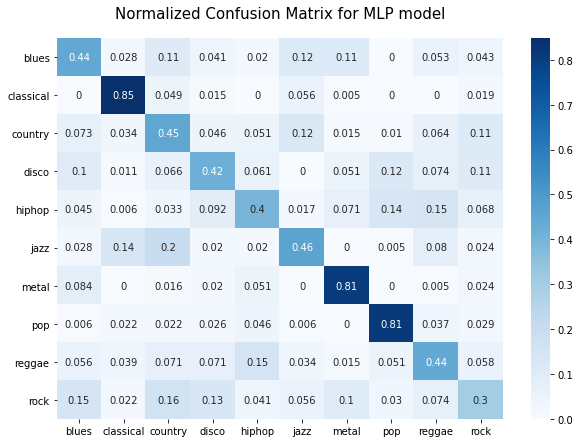

In [93]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(np.round(n_cf_matrix, 3), 
            annot=True,
            cmap='Blues',
            xticklabels = genres,
            yticklabels = genres)
plt.title('Normalized Confusion Matrix for MLP model',pad=20, fontdict={
    'fontsize':15
})
plt.savefig('Confusion_Matrix_for_MLP')

# Plotting Model Architecture

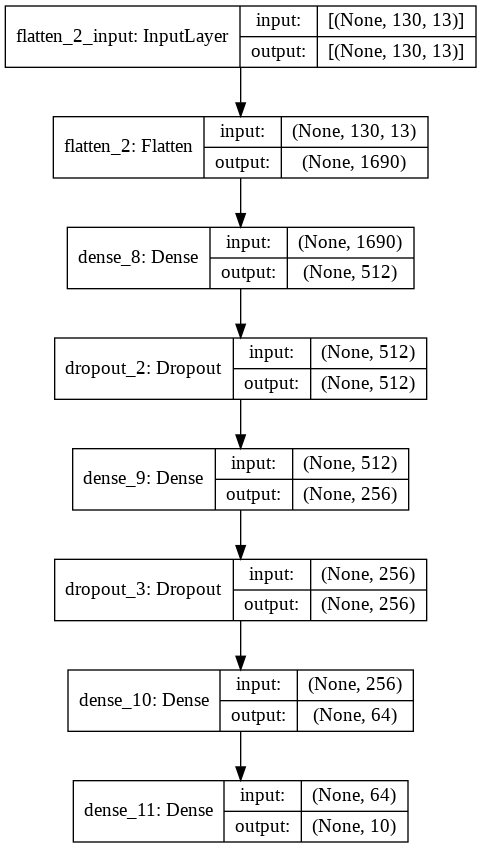

In [68]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(new_model, to_file='MLP_model.png', show_shapes=True)

# Saving Model

In [42]:
new_model.save('MLP_model_mfcc13_G.h5')

# Making Predictions on Test Dataset

In [78]:
X_test.shape

(1898, 130, 13)

In [72]:
def make_prediction(model, X, y):
    X_to_predict= np.expand_dims(X,0)

    #perfrom predicition
    prediction = model.predict(X_to_predict)
    predicted_index = np.argmax(prediction, axis=1)
    predicted_output = encoder.inverse_transform([predicted_index])[0]
    print(f'Original Label: {encoder.inverse_transform([y_to_predict])[0]} \n Predicted Output: {predicted_output}')
    return predicted_output

In [80]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[239]
y_to_predict = y_test[239]

predicted_output = make_prediction(model, X_to_predict, y_to_predict)

Original Label: hiphop 
 Predicted Output: hiphop


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [77]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[600]
y_to_predict = y_test[600]

make_prediction(model, X_to_predict, y_to_predict)

Original Label: blues 
 Predicted Output: blues


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'blues'

In [81]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[15]
y_to_predict = y_test[15]

make_prediction(model, X_to_predict, y_to_predict)

Original Label: country 
 Predicted Output: blues


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'blues'

In [82]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[666]
y_to_predict = y_test[666]

make_prediction(model, X_to_predict, y_to_predict)

Original Label: reggae 
 Predicted Output: reggae


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'reggae'